In [46]:
# install
# !pip install pytorch-pretrained-bert pytorch-nlp keras scikit-learn matplotlib tensorflow

#https://towardsdatascience.com/bert-for-dummies-step-by-step-tutorial-fb90890ffe03 

In [1]:
# BERT imports
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

UsageError: Line magic function `%` not found.


In [2]:
df = pd.read_csv(r'J:\VOA\MABI\Deep Learning\my_DTU_project\data\skills_description.csv', sep='\t', encoding='utf-8')
df = df.rename(columns={'preferredLabel':'query', 'description': 'documents'})
df = df[['query', 'documents']]

#df['target'] = 1  # set target = 1, i.e. correct match
df.head()


# Assign wrong documents to queries by spliting df in 2 halfs
#split_index = round(len(df)/2) 
#df_fail = pd.DataFrame()
#df_fail['query'] = df['query'].copy()
#df_fail['documents'] = str()
#df_fail['documents'].iloc[:split_index] = df['documents'].iloc[split_index+1:].copy()
#df_fail['documents'].iloc[split_index:] = df['documents'].iloc[:split_index+1].copy()
#df_fail['target'] = 0 # set target = 0, i.e. not a correct match

## Append dataframes 
#df = df.append(df_fail, ignore_index=True)
#df

,query,documents
0,lede musikalsk personale,Tildele og forvalte personaleopgaver på område...
1,føre tilsyn med fængselsprocedurer,Føre tilsyn med driften af et fængsel eller an...
2,anvende antioppressiv praksis,"Identificere undertrykkelse i samfund, økonomi..."
3,kontrollere overensstemmelse med jernbaneforsk...,"Inspicere rullende materiel, komponenter og sy..."
4,identificere tilgængelige tjenester,"Identificere de forskellige tjenester, der er ..."


In [3]:
# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device=="cuda":
    n_gpu = torch.cuda.device_count()
    torch.cuda.get_device_name(0)
    print(f'Running on {device} with {n_gpu} number of GPUs')
else:
    print(f'Running on {device}. Be patient...')

Running on cpu. Be patient...


In [4]:
# add special ColBERT tokens to queries and documents
queries = ["[CLS] " + query + " [SEP]" for query in df['query']]

documents =  ["[CLS] " + query + " [SEP]" for query in df['documents']]

print("Example of query:\n", queries[0])
print("\nExample of document:\n", documents[0])

Example of query:
 [CLS] [Q] lede musikalsk personale [SEP]

Example of document:
 [CLS] [D] Tildele og forvalte personaleopgaver på områder såsom instrumentering, bearbejdning, reproduktion af musik og stemmetræning. [SEP]


In [5]:
#from transformers import AutoTokenizer, AutoModelForQuestionAnswering

#tokenizer = AutoTokenizer.from_pretrained(r"J:\VOA\MABI\Deep Learning\my_DTU_project\Models\danish-bert-botxo-qa-squad")
#model = AutoModelForQuestionAnswering.from_pretrained(r"J:\VOA\MABI\Deep Learning\my_DTU_project\Models\danish-bert-botxo-qa-squad")


#tokenizer = AutoTokenizer.from_pretrained(r'J:\VOA\MABI\Deep Learning\my_DTU_project\Models\danish_bert_uncased_v2\bert_config.json')
#model = AutoModelForPreTraining.from_pretrained(r'J:\VOA\MABI\Deep Learning\my_DTU_project\Models\danish_bert_uncased_v2\bert_config.json')

In [6]:
# Tokenize with BERT tokenizer
model_path = r'J:\VOA\MABI\Deep Learning\my_DTU_project\Models\danish_bert_uncased_v2'
tokenizer = BertTokenizer.from_pretrained(model_path, do_lower_case=True)

#tokenize queries
tokenized_texts = [tokenizer.tokenize(sent) for sent in queries]

# Tokenize documents
tokenized_docs = [tokenizer.tokenize(doc) for doc in documents]

print(f'Tokenize the first sentence: \n {tokenized_texts[0]}')
print (f'\nTokenize the first document: \n {tokenized_docs[0]}')

Tokenize the first sentence: 
 ['[CLS]', '[UNK]', 'q', '[UNK]', 'lede', 'musikalsk', 'personale', '[SEP]']

Tokenize the first document: 
 ['[CLS]', '[UNK]', 'd', '[UNK]', 'tildele', 'og', 'forvalt', '##e', 'personale', '##opgaver', 'pa', 'om', '##rad', '##er', 'sas', '##om', 'instrumenter', '##ing', ',', 'bearbejdning', ',', 'reproduktion', 'af', 'musik', 'og', 'stemme', '##træning', '.', '[SEP]']


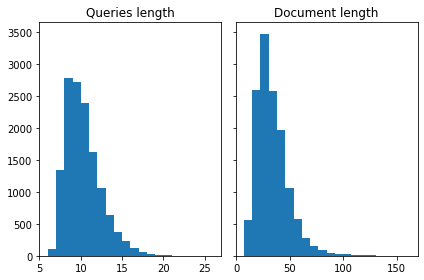

In [7]:
# Length of sequences
len_queries = [len(x) for x in tokenized_texts]
len_documents = [len(x) for x in tokenized_docs]

# Plot length of queries and documents
n_bins = 20

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

# We can set the number of bins with the *bins* keyword argument.
axs[0].hist(len_queries, bins=n_bins)
axs[0].set_title('Queries length',fontsize=12)
axs[1].hist(len_documents, bins=n_bins)
axs[1].set_title('Document length',fontsize=12)
plt.show()

Based on eye-balling the plot we determine to set maximum sequence length og queries to 24 and documents to 128

In [8]:
# Set the maximum query length. 
MAX_LEN_Q = 24

# Pad our input tokens
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
q_input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
q_input_ids = pad_sequences(q_input_ids, maxlen=MAX_LEN_Q, dtype="long", truncating="post", padding="post")
print(f'Shape of query ids:\n q_input_ids.shape = {q_input_ids.shape}')

Shape of query ids:
 q_input_ids.shape = (13485, 24)


In [9]:
# Create query attention masks
q_attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in q_input_ids:
  seq_mask = [float(i>0) for i in seq]
  q_attention_masks.append(seq_mask)

print(f'Shape of query attention mask:\n q_attention_masks = {np.shape(q_attention_masks)}')

assert q_input_ids.shape == np.shape(q_attention_masks), 'dimensions of q_input_ids and q_attention_mask do not match' 

Shape of query attention mask:
 q_attention_masks = (13485, 24)


In [10]:
# Set the maximum document length. 
MAX_LEN_DOC = 128
# Pad our input tokens
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
d_input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_docs]
d_input_ids = pad_sequences(d_input_ids, maxlen=MAX_LEN_DOC, dtype="long", truncating="post", padding="post")
print(f'Shape of input_ids.shape: {d_input_ids.shape}')

Shape of input_ids.shape: (13485, 128)


In [11]:
# Create attention masks for documents
d_attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in d_input_ids:
  seq_mask = [float(i>0) for i in seq]
  d_attention_masks.append(seq_mask)

print(f'Shape of d_attention_masks: {np.shape(d_attention_masks)}')

assert d_input_ids.shape == np.shape(d_attention_masks), 'dimensions of document d_input_ids and d_attention_mask do not match' 

Shape of d_attention_masks: (13485, 128)


# Import model
Queries and documents have now been tokenized to the vocabolary

In [12]:
from transformers import BertConfig
from transformers import BertModel

config = BertConfig.from_pretrained(model_path + r'\bert_config.json')
bert_base = BertModel(config)

#param_optimizer = list(bert_base.named_parameters())
#print(bert_base)

In [13]:
from torch import nn
import torch.nn.functional as F

class CustomBERTModel(nn.Module):
    def __init__(self):
          super(CustomBERTModel, self).__init__()
          self.bert = bert_base 
          ### New layers:
          self.linear1 = nn.Linear(768, 32) # 32 is "low" for faster computation of MaxSim (it is independent of sequence lentgh)
          

    def forward(self, ids, mask):
          sequence_output, pooled_output = self.bert(ids, attention_mask=mask) # sequence_output shape is: (batch_size, sequence_length, 768)
               
          # We apply the linear layer in line with ColBERT paper. The linear layer (which applies a linear transformation)
          # takes as input the hidden states of all tokens (so seq_len times a vector of size 768, each corresponding to
          # a single token in the input sequence) and outputs 32 numbers for every token
          # so the logits are of shape (batch_size, sequence_length, 32)
          sequence_output = self.linear1(sequence_output)
          sequence_output = F.softmax(sequence_output, dim=1)

          #linear2_output = self.linear2(linear2_output)

          return sequence_output

In [14]:
# Try model on first 10 query and document pairs
sample_size = 100
q_id    = torch.tensor(q_input_ids[:sample_size]).to(torch.device(device)).to(torch.int64)
q_mask  = torch.tensor(q_attention_masks[:sample_size]).to(torch.device(device)).to(torch.int64)

d_id    = torch.tensor(d_input_ids[:sample_size]).to(torch.device(device)).to(torch.int64)
d_mask  = torch.tensor(d_attention_masks[:sample_size]).to(torch.device(device)).to(torch.int64)

In [15]:
#bert_base.to(torch.device(device))
my_model  = CustomBERTModel()
my_model.to(torch.device(device))

#BERT_base: q_outputs = bert_base(q_id, attention_mask=q_mask)
q_outputs = my_model(q_id, mask=q_mask)


# BERT_base: d_outputs = bert_base(d_id, attention_mask=d_mask) 
d_outputs = my_model(d_id, mask=d_mask)



#With bert_base shape is: torch.Size([10, 24, 768]) and torch.Size([10, 128, 768])
print(q_outputs.shape) 
print(d_outputs.shape) 

# [1] må være model output...

torch.Size([100, 24, 32])
torch.Size([100, 128, 32])


In [16]:
# Example to convince yourself about MaxSim kan be done woth matrix multiplication

# set batch number to an integer to evaluate a singe query-document pair  
batch_no = 1

# define a sample of a query embedding and a transposed document embedding
q = q_outputs[batch_no]
d = torch.t(d_outputs[batch_no])

print('Shape of query embedding and transposed document embedding:')
print(f'q shape:   ', q.shape )
print(f'd^T shape: ', d.shape)

print(f'\nq*d^T shape:', torch.matmul(q,d).shape)

# Find maximum value in q*d^T for each query token 
maks_qd, maks_inds = torch.max(torch.matmul(q,d), dim=1)
print(f'\nmax(q*d).shape', maks_qd.shape)

sum_qd = torch.sum(maks_qd)
print(f'\nsum(max(q*d)) = ', sum_qd)

Shape of query embedding and transposed document embedding:
q shape:    torch.Size([24, 32])
d^T shape:  torch.Size([32, 128])

q*d^T shape: torch.Size([24, 128])

max(q*d).shape torch.Size([24])

sum(max(q*d)) =  tensor(0.3091, grad_fn=<SumBackward0>)


In [17]:
# Check how to Transpose document embeddings for entire batch at ones 
print('d_outputs.shape:                ', d_outputs.shape)
print('d_outputs.permute(0,2,1).shape: ', d_outputs.permute(0,2,1).shape)

# Check whether permutation is in fact a matrix transform for each batch: 
assert all(d_outputs[0][0,:] == d_outputs.permute(0,2,1)[0][:,0]), 'AssertError: matrix transpose is wrong'

d_outputs.shape:                 torch.Size([100, 128, 32])
d_outputs.permute(0,2,1).shape:  torch.Size([100, 32, 128])


In [18]:
#%%
# Now batch multiply, i.e. tensor multiplication or rather matrix mulætiply for each batch
batch_mm = torch.bmm(q_outputs, d_outputs.permute(0,2,1))
print('batch_mm shape: ', batch_mm.shape)

# Find maximum value in q*d^T for each query token in each batch
maks_qd, maks_inds = torch.max(batch_mm, dim=2)
print('maks_qd.shape:  ', maks_qd.shape)


sum_qd = torch.sum(maks_qd, dim=1)
sum_qd.shape

batch_mm shape:  torch.Size([100, 24, 128])
maks_qd.shape:   torch.Size([100, 24])


torch.Size([100])

In summary, given a query sequence $q = q_0 q_1...q_l$ and a document sequence $d = d_0 d_1...d_n$, we compute the bags of embeddings $E_q$ and $E_d$ in the following manner:

* $E_q$ := Normalize( CNN( BERT(“[Q]$q_0 q_1...q_l$ ##...#”) ) )

* $E_d$ := Normalize( CNN( BERT(“[D]$d_0 d_1...d_l$ ...d_n”) ) )

where '#' refers to the [mask] tokens. In my implementation of ColBERT the output dimensions are as follow:
\begin{align*}
    dim(E_q) = [batch_{size} \times 24 \times 32] \\
    dim(E_d) = [batch_{size} \times 128 \times 32]
\end{align*}


The relevancy score, MaxSim, is defined as follows:

$$ S_{q,d} = \sum_{i \in ||E_q||} \max_{j \in ||E_d||} E_{q_i} * E_{d_j}^T$$

In [ ]:

def MaxSim(q, D):
    '''Takes in a query, q, and return it's similarity score to
        all documents in  D.'''

    # repeat q for faster matrix multiplication (faster than loop)
    batch_size=D.shape[0]
    q_X = q.repeat(batch_size, 1, 1)
    
    # multiply the same query q against all documents (in D)
    batch_mm = torch.bmm(q_X, D.permute(0,2,1))
    
    maks, _ = torch.max(batch_mm, dim=2) # dim=1 or dim=2
    
    # Sum over maximum values --> return vector of length len(D)
    S_qD = torch.sum(maks, dim=1)
    
    return S_qD

In [ ]:
most_similar_doc_score = []
most_similar_docID = []

 # Define D as all documents:
D = d_outputs

for q_no in tqdm(range(sample_size)):
    
    # Select one query
    q = q_outputs[q_no]

    # Compute similarity scores for all 
    S_qD = MaxSim(q, D)
    maks, maks_id = torch.max(S_qD, dim=0)

    most_similar_doc_score.append(float(maks))
    most_similar_docID.append(int(maks_id))

# Training / Fine-tuning of model 

In [ ]:
#tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-italian-xxl-cased")

model = CustomBERTModel() # You can pass the parameters if required to have more flexible model
model.to(torch.device(device)) ## can be gpu
criterion = nn.CrossEntropyLoss() ## If required define your own criterion# TODO
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()))

for epoch in epochs:
    for zip(q_batch, d_batch) in zip(q_data_loader, d_data_loader): ## If you have a DataLoader()  object to get the data.# TODO

        # assign batch of query and document data
        q_data = q_batch[0]
        targets = q_batch[1] ## assuming that data loader returns a tuple of data and its targets
         
        d_data = d_batch[0]
        #d_targets = d_batch[1] ## assuming that data loader returns a tuple of data and its targets
        # Target is the same for query and documents. # TODO

        optimizer.zero_grad()   

        ##### Queries
        #q_encoding = tokenizer.batch_encode_plus(q_data, return_tensors='pt', padding=True, truncation=True,max_length=50, add_special_tokens = True)
        q_outputs = model(q_input_ids, attention_mask=q_attention_masks)
        q_outputs = F.log_softmax(q_outputs, dim=1)
        #q_input_ids = q_encoding['input_ids']
        #q_attention_mask = q_encoding['attention_mask']
        
        ##### Documents
        d_outputs = model(d_input_ids, attention_mask=d_attention_masks)
        d_outputs = F.log_softmax(q_outputs, dim=1)
        
        maxsim = MaxSim(q_outputs, d_outputs) # vector of length batch_size
        loss = criterion(maxsim, targets)
               
        loss.backward()
        optimizer.step()

In [152]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(df, batch_size=64, shuffle=True)

In [156]:
#for batch in train_dataloader:
#    print(batch.item())